# Notebook 06 — Model Evaluation and Selection


## Step 1 — Imports, paths, and global config

In [10]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.calibration import calibration_curve

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
sns.set(style="whitegrid")

RANDOM_SEED = 42

PATIENT_COL = "Patient_ID"
TIME_COL = "ICULOS"
TARGET_COL = "SepsisLabel"
LABEL_COL = "Label_6h"


def find_project_root() -> Path:
    cur = Path.cwd().resolve()
    for candidate in [cur, *cur.parents]:
        if (candidate / "notebooks").exists() and (candidate / "reports").exists():
            return candidate
    return cur


PROJECT_ROOT = find_project_root()
REPORTS_ROOT = PROJECT_ROOT / "reports"

RESULTS_LABELING = REPORTS_ROOT / "results" / "02_labeling_eda"
RESULTS_BASELINES = REPORTS_ROOT / "results" / "03_feature_engineering_baselines"
RESULTS_BOOSTING = REPORTS_ROOT / "results" / "04_time_window_boosting"
RESULTS_SEQ = REPORTS_ROOT / "results" / "05_sequence_models"

RESULTS_THIS = REPORTS_ROOT / "results" / "06_model_evaluation"
FIGURES_THIS = REPORTS_ROOT / "figures" / "06_model_evaluation"

RESULTS_THIS.mkdir(parents=True, exist_ok=True)
FIGURES_THIS.mkdir(parents=True, exist_ok=True)

EXPORTED_FIGURES: list[tuple[str, plt.Figure]] = []

print("cwd:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("This notebook results dir:", RESULTS_THIS)
print("This notebook figures dir:", FIGURES_THIS)

cwd: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\notebooks
PROJECT_ROOT: C:\Users\marta\PyCharmMiscProject\sepsis-predictor
This notebook results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation
This notebook figures dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\06_model_evaluation


## Step 2 — Load labeled cohorts with sepsis onset time

In [11]:
train_label_path = RESULTS_LABELING / "02_labeling_eda_train.csv"
test_label_path = RESULTS_LABELING / "02_labeling_eda_test.csv"

print("Loading labeled datasets with sepsis onset from:")
print("  train:", train_label_path)
print("  test :", test_label_path)

assert train_label_path.exists(), f"Missing file: {train_label_path}"
assert test_label_path.exists(), f"Missing file: {test_label_path}"

train_label_df = pd.read_csv(train_label_path, low_memory=False)
test_label_df = pd.read_csv(test_label_path, low_memory=False)

for name, df in [("train_label_df", train_label_df), ("test_label_df", test_label_df)]:
    for col in [PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "sepsis_onset_time"]:
        assert col in df.columns, f"{col} missing in {name}"

print("\nLoaded labeled cohorts:")
print("  train_label_df:", train_label_df.shape)
print("  test_label_df :", test_label_df.shape)
display(train_label_df[[PATIENT_COL, TIME_COL, LABEL_COL, "sepsis_onset_time"]].head())

Loading labeled datasets with sepsis onset from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_train.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_test.csv

Loaded labeled cohorts:
  train_label_df: (1220925, 19)
  test_label_df : (306301, 19)


,Patient_ID,ICULOS,Label_6h,sepsis_onset_time
0,1,1,0,NaN
1,1,2,0,NaN
2,1,3,0,NaN
3,1,4,0,NaN
4,1,5,0,NaN


## Step 3 — Configure models and load risk trajectories

In [12]:
from dataclasses import dataclass


@dataclass
class ModelSpec:
    model_id: str
    display_name: str
    source_dir: Path
    train_file: str
    test_file: str
    prob_col: str


MODEL_SPECS: list[ModelSpec] = [
    ModelSpec(
        model_id="logreg_baseline",
        display_name="Logistic regression (6h window features)",
        source_dir=RESULTS_BASELINES,
        train_file="03_logreg_risk_trajectories_trainval.csv",
        test_file="03_logreg_risk_trajectories_test.csv",
        prob_col="risk_logreg",
    ),
    ModelSpec(
        model_id="rf_baseline",
        display_name="Random forest (6h window features)",
        source_dir=RESULTS_BASELINES,
        train_file="03_rf_risk_trajectories_trainval.csv",
        test_file="03_rf_risk_trajectories_test.csv",
        prob_col="risk_rf",
    ),
    ModelSpec(
        model_id="xgb_baseline",
        display_name="XGBoost baseline (6h window features)",
        source_dir=RESULTS_BASELINES,
        train_file="03_xgb_risk_trajectories_trainval.csv",
        test_file="03_xgb_risk_trajectories_test.csv",
        prob_col="risk_xgb_base",
    ),
    ModelSpec(
        model_id="xgb_timewindow",
        display_name="XGBoost + multi-window features (3/6/12h)",
        source_dir=RESULTS_BOOSTING,
        train_file="04_xgb_risk_trajectories_trainval.csv",
        test_file="04_xgb_risk_trajectories_test.csv",
        prob_col="risk_xgb_tw",
    ),
    ModelSpec(
        model_id="gru_seq",
        display_name="GRU sequence model (24h history)",
        source_dir=RESULTS_SEQ,
        train_file="05_gru_risk_trajectories_trainval.csv",
        test_file="05_gru_risk_trajectories_test.csv",
        prob_col="risk_gru_seq",
    ),
    ModelSpec(
        model_id="lstm_seq",
        display_name="LSTM sequence model (24h history)",
        source_dir=RESULTS_SEQ,
        train_file="05_lstm_risk_trajectories_trainval.csv",
        test_file="05_lstm_risk_trajectories_test.csv",
        prob_col="risk_lstm_seq",
    ),
]


model_dfs = {}

for spec in MODEL_SPECS:
    train_traj_path = spec.source_dir / spec.train_file
    test_traj_path = spec.source_dir / spec.test_file

    print(f"\n[{spec.model_id}] Loading risk trajectories from:")
    print("  train:", train_traj_path)
    print("  test :", test_traj_path)

    assert train_traj_path.exists(), f"Missing file: {train_traj_path}"
    assert test_traj_path.exists(), f"Missing file: {test_traj_path}"

    train_traj_df = pd.read_csv(train_traj_path, low_memory=False)
    test_traj_df = pd.read_csv(test_traj_path, low_memory=False)

    for col in [PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, spec.prob_col]:
        assert col in train_traj_df.columns, f"{col} missing in {spec.model_id} train_traj_df"
        assert col in test_traj_df.columns, f"{col} missing in {spec.model_id} test_traj_df"

    train_merged = train_traj_df.merge(
        train_label_df[[PATIENT_COL, TIME_COL, "sepsis_onset_time"]],
        on=[PATIENT_COL, TIME_COL],
        how="left",
        validate="one_to_one",
    )
    test_merged = test_traj_df.merge(
        test_label_df[[PATIENT_COL, TIME_COL, "sepsis_onset_time"]],
        on=[PATIENT_COL, TIME_COL],
        how="left",
        validate="one_to_one",
    )

    model_dfs[spec.model_id] = {
        "spec": spec,
        "train": train_merged,
        "test": test_merged,
    }

    print(
        f"  train rows: {train_merged.shape[0]}, test rows: {test_merged.shape[0]}, "
        f"patients train/test: {train_merged[PATIENT_COL].nunique()}/"
        f"{test_merged[PATIENT_COL].nunique()}"
    )

display(next(iter(model_dfs.values()))["train"].head())



[logreg_baseline] Loading risk trajectories from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_logreg_risk_trajectories_trainval.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_logreg_risk_trajectories_test.csv
  train rows: 1061297, test rows: 266361, patients train/test: 31731/7937

[rf_baseline] Loading risk trajectories from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_rf_risk_trajectories_trainval.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_rf_risk_trajectories_test.csv
  train rows: 1061297, test rows: 266361, patients train/test: 31731/7937

[xgb_baseline] Loading risk trajectories from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_xgb_risk_t

,Patient_ID,ICULOS,SepsisLabel,Label_6h,risk_logreg,split_03,sepsis_onset_time
0,1,6,0,0,0.311567,train,NaN
1,1,7,0,0,0.322834,train,NaN
2,1,8,0,0,0.322510,train,NaN
3,1,9,0,0,0.330707,train,NaN
4,1,10,0,0,0.301476,train,NaN


## Step 4 — Helper functions for metric computation


In [13]:
def compute_global_metrics(y_true: np.ndarray, probs: np.ndarray) -> dict:
    auroc = metrics.roc_auc_score(y_true, probs)
    auprc = metrics.average_precision_score(y_true, probs)
    brier = metrics.brier_score_loss(y_true, probs)
    return {
        "auroc": auroc,
        "auprc": auprc,
        "brier": brier,
    }


def threshold_metrics(y_true: np.ndarray, probs: np.ndarray, threshold: float) -> dict:
    y_pred = (probs >= threshold).astype(int)

    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    f1 = metrics.f1_score(y_true, y_pred, zero_division=0)

    return {
        "threshold": threshold,
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "sensitivity": sens,
        "specificity": spec,
        "ppv": ppv,
        "npv": npv,
        "f1": f1,
    }


def alerts_per_100_patient_days(df: pd.DataFrame, prob_col: str, threshold: float) -> float:
    y_pred = (df[prob_col].values >= threshold).astype(int)
    alerts = y_pred.sum()

    hours_per_patient = df.groupby(PATIENT_COL)[TIME_COL].count()
    total_patient_days = hours_per_patient.sum() / 24.0

    if total_patient_days == 0:
        return np.nan

    return alerts / total_patient_days * 100.0


def compute_time_gain(df: pd.DataFrame, prob_col: str, threshold: float) -> pd.DataFrame:
    df = df.copy()
    df["alert_flag"] = (df[prob_col] >= threshold).astype(int)

    onset_by_patient = df.groupby(PATIENT_COL)["sepsis_onset_time"].max()

    first_alert_time = (
        df.loc[df["alert_flag"] == 1]
        .groupby(PATIENT_COL)[TIME_COL]
        .min()
    )

    out_rows = []
    for pid, onset_time in onset_by_patient.items():
        patient_is_septic = not np.isnan(onset_time)
        first_alert = first_alert_time.get(pid, np.nan)

        if patient_is_septic and not np.isnan(first_alert):
            time_gain = onset_time - first_alert
        elif patient_is_septic and np.isnan(first_alert):
            time_gain = np.nan
        else:
            time_gain = np.nan

        out_rows.append(
            {
                PATIENT_COL: pid,
                "septic": int(patient_is_septic),
                "sepsis_onset_time": onset_time,
                "first_alert_time": first_alert,
                "time_gain_hours": time_gain,
            }
        )

    return pd.DataFrame(out_rows)

## Step 5 — Global AUROC/AUPRC/Brier per model (TEST set)

In [14]:
global_rows = []

for model_id, payload in model_dfs.items():
    spec = payload["spec"]
    df_test = payload["test"]

    y_true = df_test[LABEL_COL].values
    probs = df_test[spec.prob_col].values

    g_metrics = compute_global_metrics(y_true, probs)
    row = {
        "model_id": model_id,
        "model_name": spec.display_name,
        "split": "test",
        **g_metrics,
    }
    global_rows.append(row)

global_metrics_df = pd.DataFrame(global_rows)
display(global_metrics_df.sort_values("auprc", ascending=False))

global_metrics_path = RESULTS_THIS / "06_global_metrics_test.csv"
global_metrics_df.to_csv(global_metrics_path, index=False)
print("Saved global test metrics to:", global_metrics_path)

,model_id,model_name,split,auroc,auprc,brier
4,gru_seq,GRU sequence model (24h history),test,0.814126,0.061930,0.028140
5,lstm_seq,LSTM sequence model (24h history),test,0.803488,0.058403,0.032793
3,xgb_timewindow,XGBoost + multi-window features (3/6/12h),test,0.823837,0.055156,0.125483
2,xgb_baseline,XGBoost baseline (6h window features),test,0.804823,0.045339,0.130023
1,rf_baseline,Random forest (6h window features),test,0.792511,0.044287,0.009477
0,logreg_baseline,Logistic regression (6h window features),test,0.763779,0.042405,0.186536


Saved global test metrics to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation\06_global_metrics_test.csv


## Step 6 — ROC, PR, and calibration curves (TEST set)


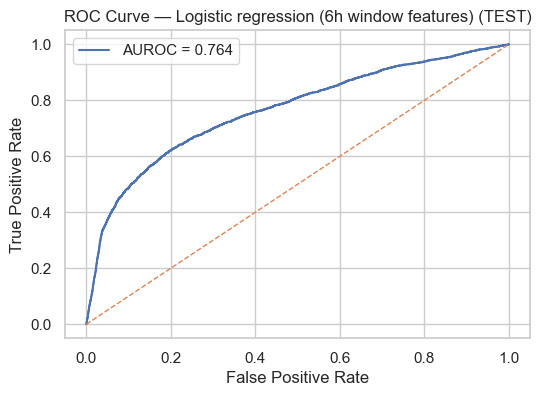

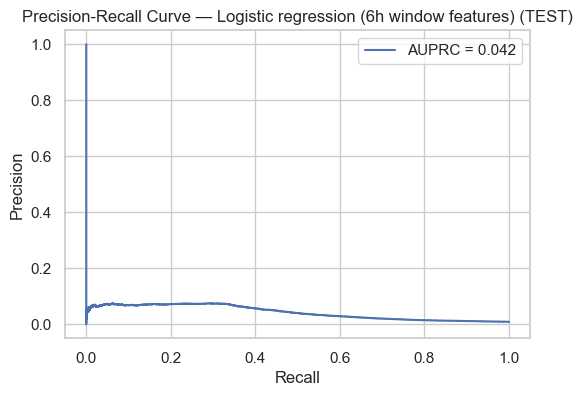

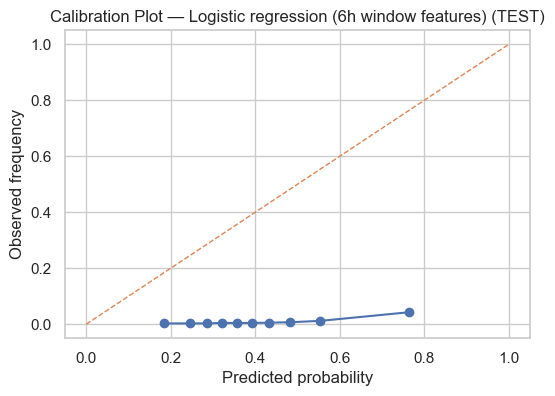

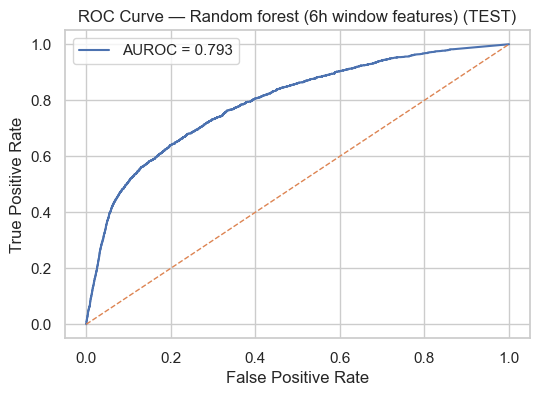

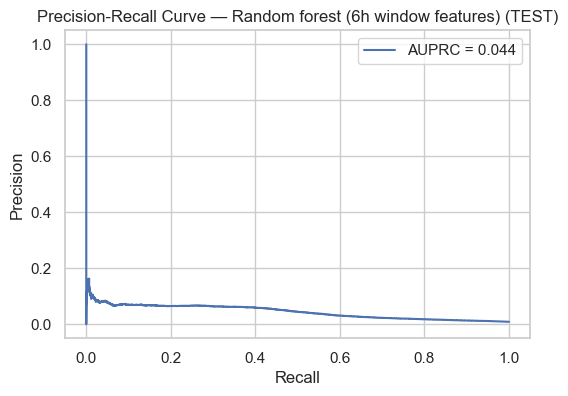

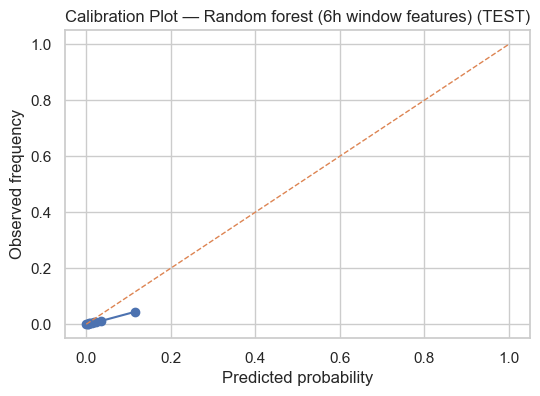

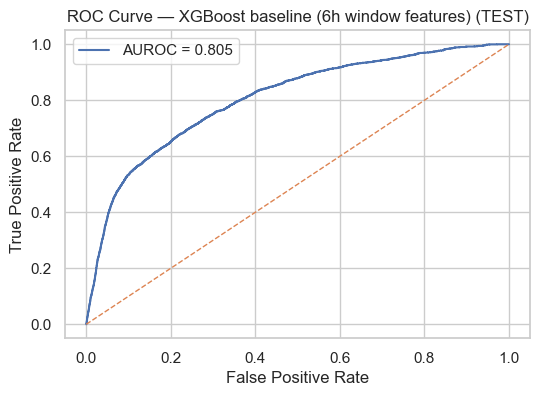

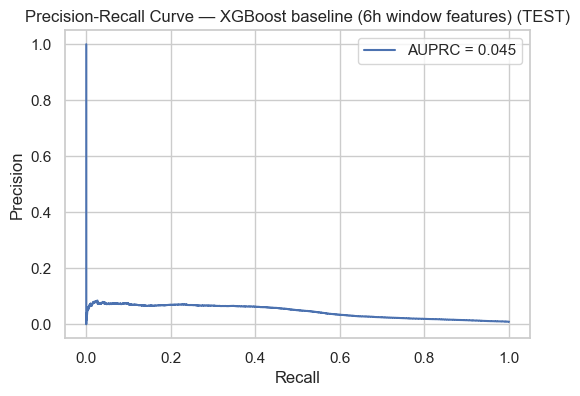

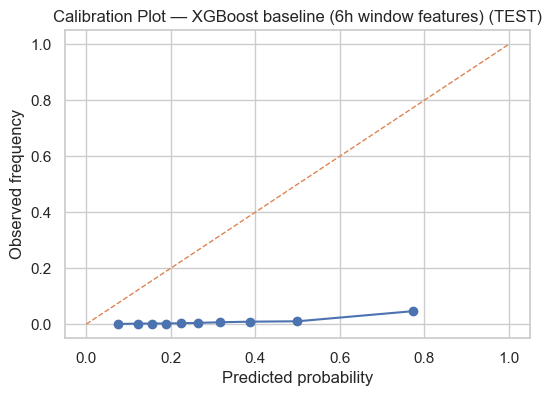

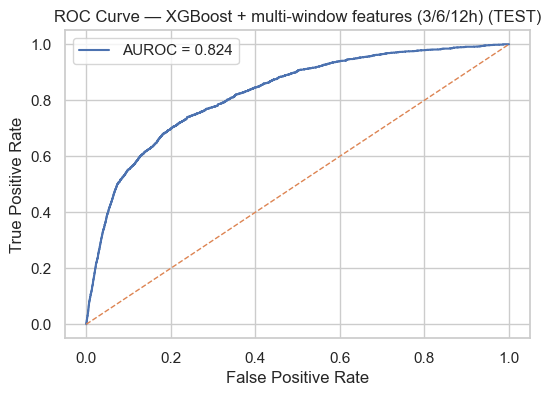

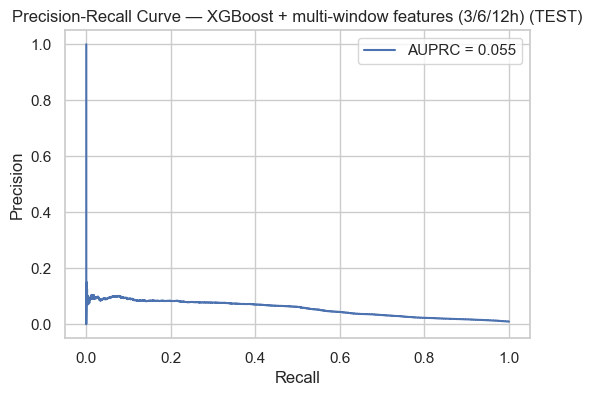

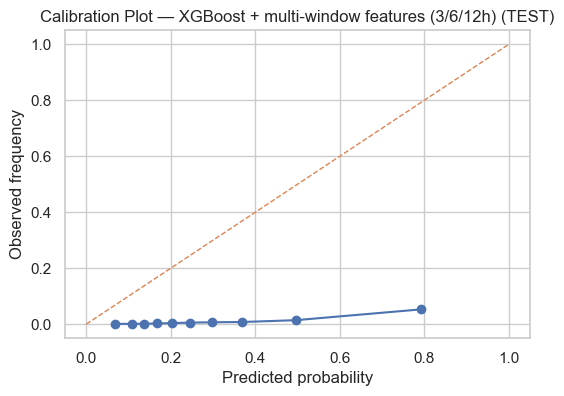

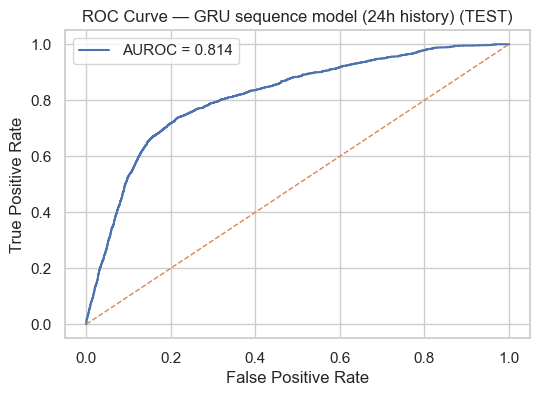

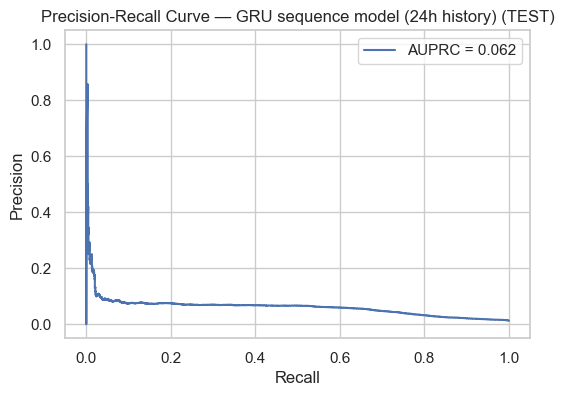

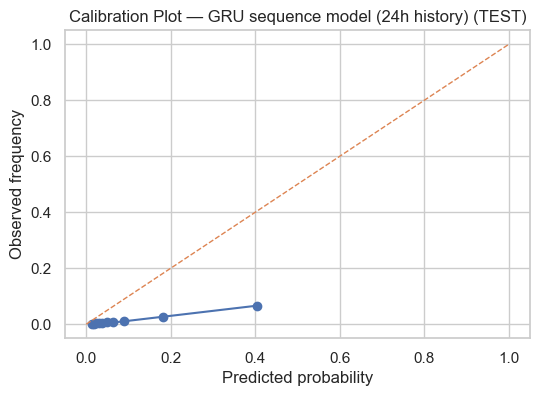

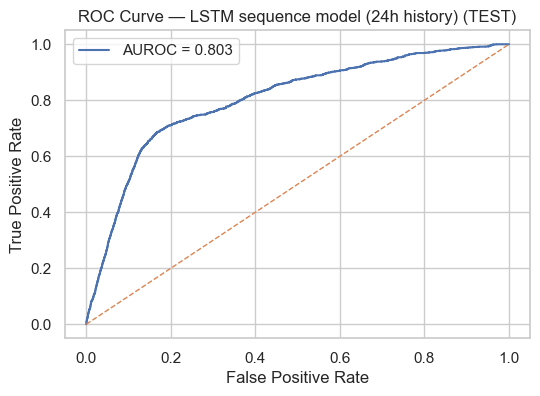

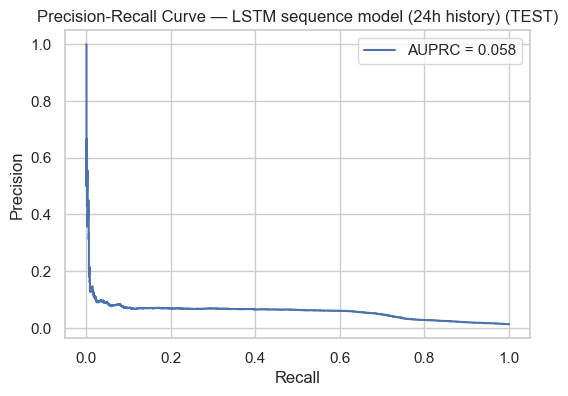

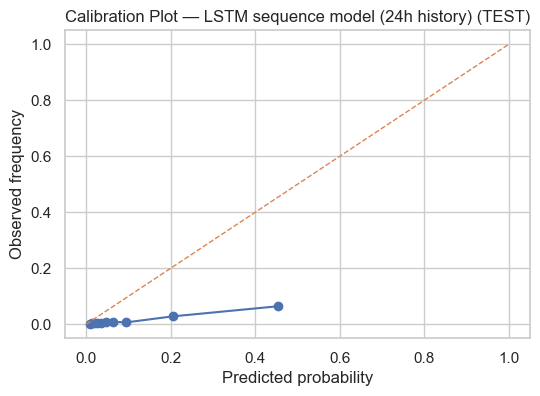

In [15]:
for model_id, payload in model_dfs.items():
    spec = payload["spec"]
    df_test = payload["test"]
    y_true = df_test[LABEL_COL].values
    probs = df_test[spec.prob_col].values

    fpr, tpr, _ = metrics.roc_curve(y_true, probs)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(fpr, tpr, label=f"AUROC = {metrics.roc_auc_score(y_true, probs):.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax.set_title(f"ROC Curve — {spec.display_name} (TEST)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    name = f"06_{model_id}_roc_test"
    EXPORTED_FIGURES.append((name, fig))
    plt.show()

    precision, recall, _ = metrics.precision_recall_curve(y_true, probs)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(recall, precision, label=f"AUPRC = {metrics.average_precision_score(y_true, probs):.3f}")
    ax.set_title(f"Precision-Recall Curve — {spec.display_name} (TEST)")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    name = f"06_{model_id}_pr_test"
    EXPORTED_FIGURES.append((name, fig))
    plt.show()

    frac_pos, mean_pred = calibration_curve(y_true, probs, n_bins=10, strategy="quantile")
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(mean_pred, frac_pos, marker="o")
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax.set_title(f"Calibration Plot — {spec.display_name} (TEST)")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    name = f"06_{model_id}_calibration_test"
    EXPORTED_FIGURES.append((name, fig))
    plt.show()

## Step 7 — Threshold sweep and alert statistics (TEST set)


In [16]:
THRESHOLDS = [0.2, 0.3, 0.5, 0.7]

rows = []

for model_id, payload in model_dfs.items():
    spec = payload["spec"]
    df_test = payload["test"]
    y_true = df_test[LABEL_COL].values
    probs = df_test[spec.prob_col].values

    for thr in THRESHOLDS:
        base = threshold_metrics(y_true, probs, thr)
        alerts_100_pd = alerts_per_100_patient_days(df_test, spec.prob_col, thr)

        row = {
            "model_id": model_id,
            "model_name": spec.display_name,
            "threshold": thr,
            "split": "test",
            "alerts_per_100_patient_days": alerts_100_pd,
            **base,
        }
        rows.append(row)

threshold_stats_df = pd.DataFrame(rows)
display(threshold_stats_df.sort_values(["model_id", "threshold"]))

threshold_stats_path = RESULTS_THIS / "06_threshold_stats_test.csv"
threshold_stats_df.to_csv(threshold_stats_path, index=False)
print("Saved threshold statistics to:", threshold_stats_path)

,model_id,model_name,threshold,split,alerts_per_100_patient_days,tp,fp,tn,fn,sensitivity,specificity,ppv,npv,f1
16,gru_seq,GRU sequence model (24h history),0.2,test,320.076023,1043,16640,114229,679,0.605691,0.872850,0.058983,0.994091,0.107498
17,gru_seq,GRU sequence model (24h history),0.3,test,249.627803,906,12885,117984,816,0.526132,0.901543,0.065695,0.993131,0.116805
18,gru_seq,GRU sequence model (24h history),0.5,test,16.815621,81,848,130021,1641,0.047038,0.993520,0.087191,0.987536,0.061109
19,gru_seq,GRU sequence model (24h history),0.7,test,0.000000,0,0,130869,1722,0.000000,1.000000,NaN,0.987013,0.000000
0,logreg_baseline,Logistic regression (6h window features),0.2,test,2245.382770,2304,246897,17117,43,0.981679,0.064834,0.009246,0.997494,0.018319
1,logreg_baseline,Logistic regression (6h window features),0.3,test,1706.907543,2139,187300,76714,208,0.911376,0.290568,0.011291,0.997296,0.022306
2,logreg_baseline,Logistic regression (6h window features),0.5,test,524.599322,1486,56736,207278,861,0.633149,0.785102,0.025523,0.995863,0.049068
3,logreg_baseline,Logistic regression (6h window features),0.7,test,140.083571,912,14635,249379,1435,0.388581,0.944567,0.058661,0.994279,0.101934
20,lstm_seq,LSTM sequence model (24h history),0.2,test,340.891916,1089,17744,113125,633,0.632404,0.864414,0.057824,0.994436,0.105960
21,lstm_seq,LSTM sequence model (24h history),0.3,test,278.009820,951,14408,116461,771,0.552265,0.889905,0.061918,0.993423,0.111352


Saved threshold statistics to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation\06_threshold_stats_test.csv


## Step 8 — Time-gain before sepsis onset (TEST set, chosen thresholds)


,model_id,model_name,threshold,median_time_gain_hours,iqr_time_gain_hours_low,iqr_time_gain_hours_high,n_septic
0,logreg_baseline,Logistic regression (6h window features),0.3,41.0,15.0,98.00,420
1,rf_baseline,Random forest (6h window features),0.3,49.0,15.5,82.00,420
2,xgb_baseline,XGBoost baseline (6h window features),0.3,42.0,14.0,99.75,420
3,xgb_timewindow,XGBoost + multi-window features (3/6/12h),0.3,42.0,13.0,97.75,375
4,gru_seq,GRU sequence model (24h history),0.3,54.0,26.0,106.00,305
5,lstm_seq,LSTM sequence model (24h history),0.3,52.0,18.0,109.00,305


Saved per-patient time-gain data to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation\06_time_gain_per_patient_test.csv


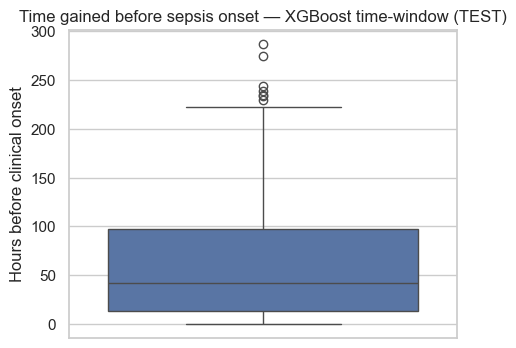

In [17]:
chosen_thresholds = {
    "logreg_baseline": 0.3,
    "rf_baseline": 0.3,
    "xgb_baseline": 0.3,
    "xgb_timewindow": 0.3,
    "gru_seq": 0.3,
    "lstm_seq": 0.3,
}

time_gain_rows = []
time_gain_summaries = []

for model_id, thr in chosen_thresholds.items():
    payload = model_dfs[model_id]
    spec = payload["spec"]
    df_test = payload["test"]

    tg_df = compute_time_gain(df_test, spec.prob_col, thr)
    tg_df["model_id"] = model_id
    tg_df["model_name"] = spec.display_name
    tg_df["threshold"] = thr

    time_gain_rows.append(tg_df)

    septic_mask = tg_df["septic"] == 1
    median_gain = tg_df.loc[septic_mask, "time_gain_hours"].median()
    iqr_gain = tg_df.loc[septic_mask, "time_gain_hours"].quantile([0.25, 0.75]).values

    summary = {
        "model_id": model_id,
        "model_name": spec.display_name,
        "threshold": thr,
        "median_time_gain_hours": median_gain,
        "iqr_time_gain_hours_low": iqr_gain[0] if len(iqr_gain) == 2 else np.nan,
        "iqr_time_gain_hours_high": iqr_gain[1] if len(iqr_gain) == 2 else np.nan,
        "n_septic": int(septic_mask.sum()),
    }
    time_gain_summaries.append(summary)

time_gain_all_df = pd.concat(time_gain_rows, ignore_index=True)
time_gain_summary_df = pd.DataFrame(time_gain_summaries)

display(time_gain_summary_df)

time_gain_path = RESULTS_THIS / "06_time_gain_per_patient_test.csv"
time_gain_all_df.to_csv(time_gain_path, index=False)
print("Saved per-patient time-gain data to:", time_gain_path)

# Simple violin/boxplot for visualizing distribution for the main model
main_model_id = "xgb_timewindow"
tg_main = time_gain_all_df[
    (time_gain_all_df["model_id"] == main_model_id)
    & (time_gain_all_df["septic"] == 1)
]

fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(
    data=tg_main,
    y="time_gain_hours",
    ax=ax,
)
ax.set_title("Time gained before sepsis onset — XGBoost time-window (TEST)")
ax.set_ylabel("Hours before clinical onset")
EXPORTED_FIGURES.append(("06_xgb_timewindow_time_gain_boxplot_test", fig))
plt.show()

In [18]:
time_gain_summary_path = RESULTS_THIS / "06_time_gain_summary_test.csv"
time_gain_summary_df.to_csv(time_gain_summary_path, index=False)
print("Saved time-gain summary to:", time_gain_summary_path)

Saved time-gain summary to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation\06_time_gain_summary_test.csv


## Step 9 — Export combined summary tables and all figures


In [19]:
summary_best = (
    threshold_stats_df.merge(
        global_metrics_df,
        on=["model_id", "model_name", "split"],
        how="left",
        suffixes=("", "_global"),
    )
)

summary_full = summary_best.merge(
    time_gain_summary_df[
        ["model_id", "model_name", "threshold",
         "median_time_gain_hours",
         "iqr_time_gain_hours_low",
         "iqr_time_gain_hours_high",
         "n_septic"]
    ],
    on=["model_id", "model_name", "threshold"],
    how="left",
)

summary_best_path = RESULTS_THIS / "06_combined_threshold_global_summary_test.csv"
summary_full_path = RESULTS_THIS / "06_combined_metrics_threshold_timegain_test.csv"

summary_best.to_csv(summary_best_path, index=False)
summary_full.to_csv(summary_full_path, index=False)

print("Saved combined global + threshold summary to:", summary_best_path)
print("Saved full combined summary (incl. time-gain) to:", summary_full_path)

for name, fig in EXPORTED_FIGURES:
    out_path = FIGURES_THIS / f"{name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved figure:", out_path)

print("\nAll figures successfully exported.")


Saved combined global + threshold summary to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation\06_combined_threshold_global_summary_test.csv
Saved full combined summary (incl. time-gain) to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\06_model_evaluation\06_combined_metrics_threshold_timegain_test.csv
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\06_model_evaluation\06_logreg_baseline_roc_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\06_model_evaluation\06_logreg_baseline_pr_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\06_model_evaluation\06_logreg_baseline_calibration_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\06_model_evaluation\06_rf_baseline_roc_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\06_model_evaluation\